In [1]:
import Strain
from Strain import DataSetStrain
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib
import math
from neucube import Reservoir
from neucube.encoder import Delta
from neucube.sampler import SpikeCount, DeSNN
from sklearn.base import BaseEstimator, TransformerMixin
from neucube.validation import Pipeline
from neucube import Reservoir
from neucube.encoder import Delta
from neucube.sampler import SpikeCount
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

importlib.reload(Strain)




<module 'Strain' from '/Users/thomasgence/Downloads/semproj-neucube/Strain.py'>

In [2]:
dataset = DataSetStrain()
dataset.fetch_data(range(4, 9))  
dataset.split_into_batches() 


System 1 Batches Shape: torch.Size([543, 200, 8])
System 2 Batches Shape: torch.Size([543, 200, 5])


In [3]:
#y = dataset.convert_gt_spikes_to_tensor()
y = dataset.generate_classes()
y = np.array(y)

{0: {0: [], 1: [(0.06234375, 3.84)], 2: [(0.013015625, 3.84)], 3: [(0.018414063, 3.84)]}, 1: {0: [], 1: [], 2: [], 3: []}, 2: {0: [], 1: [], 2: [], 3: []}, 3: {0: [], 1: [(0.00334375, 15.66)], 2: [(0.00159375, 15.68)], 3: [(0.0045078127, 15.7)]}, 4: {0: [], 1: [], 2: [], 3: []}, 5: {0: [], 1: [], 2: [], 3: []}, 6: {0: [], 1: [(0.009, 27.4)], 2: [(0.01421875, 27.38)], 3: [(0.013828125, 27.38)]}, 7: {0: [], 1: [], 2: [], 3: []}, 8: {0: [], 1: [], 2: [], 3: []}, 9: {0: [], 1: [(0.044140626, 39.5)], 2: [(0.060875, 39.5)], 3: [(0.008828125, 39.5)]}, 10: {0: [], 1: [], 2: [], 3: []}, 11: {0: [], 1: [], 2: [], 3: []}, 12: {0: [], 1: [(0.018390626, 51.48)], 2: [(0.006125, 51.48)], 3: [(0.02346875, 51.48)]}, 13: {0: [], 1: [], 2: [], 3: []}, 14: {0: [], 1: [], 2: [], 3: []}, 15: {0: [], 1: [], 2: [], 3: []}, 16: {0: [], 1: [(0.0033046876, 64.02)], 2: [(0.00146875, 64.04)], 3: [(0.00121875, 64.04)]}, 17: {0: [], 1: [], 2: [], 3: []}, 18: {0: [], 1: [], 2: [], 3: []}, 19: {0: [], 1: [(0.001421875

In [27]:
# Count each class
unique, counts = np.unique(y, return_counts=True)
# Print the class distribution
y_total_counts = dict(zip(unique, counts))
print(y_total_counts)

{1: 410, 2: 100, 3: 20, 4: 13}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

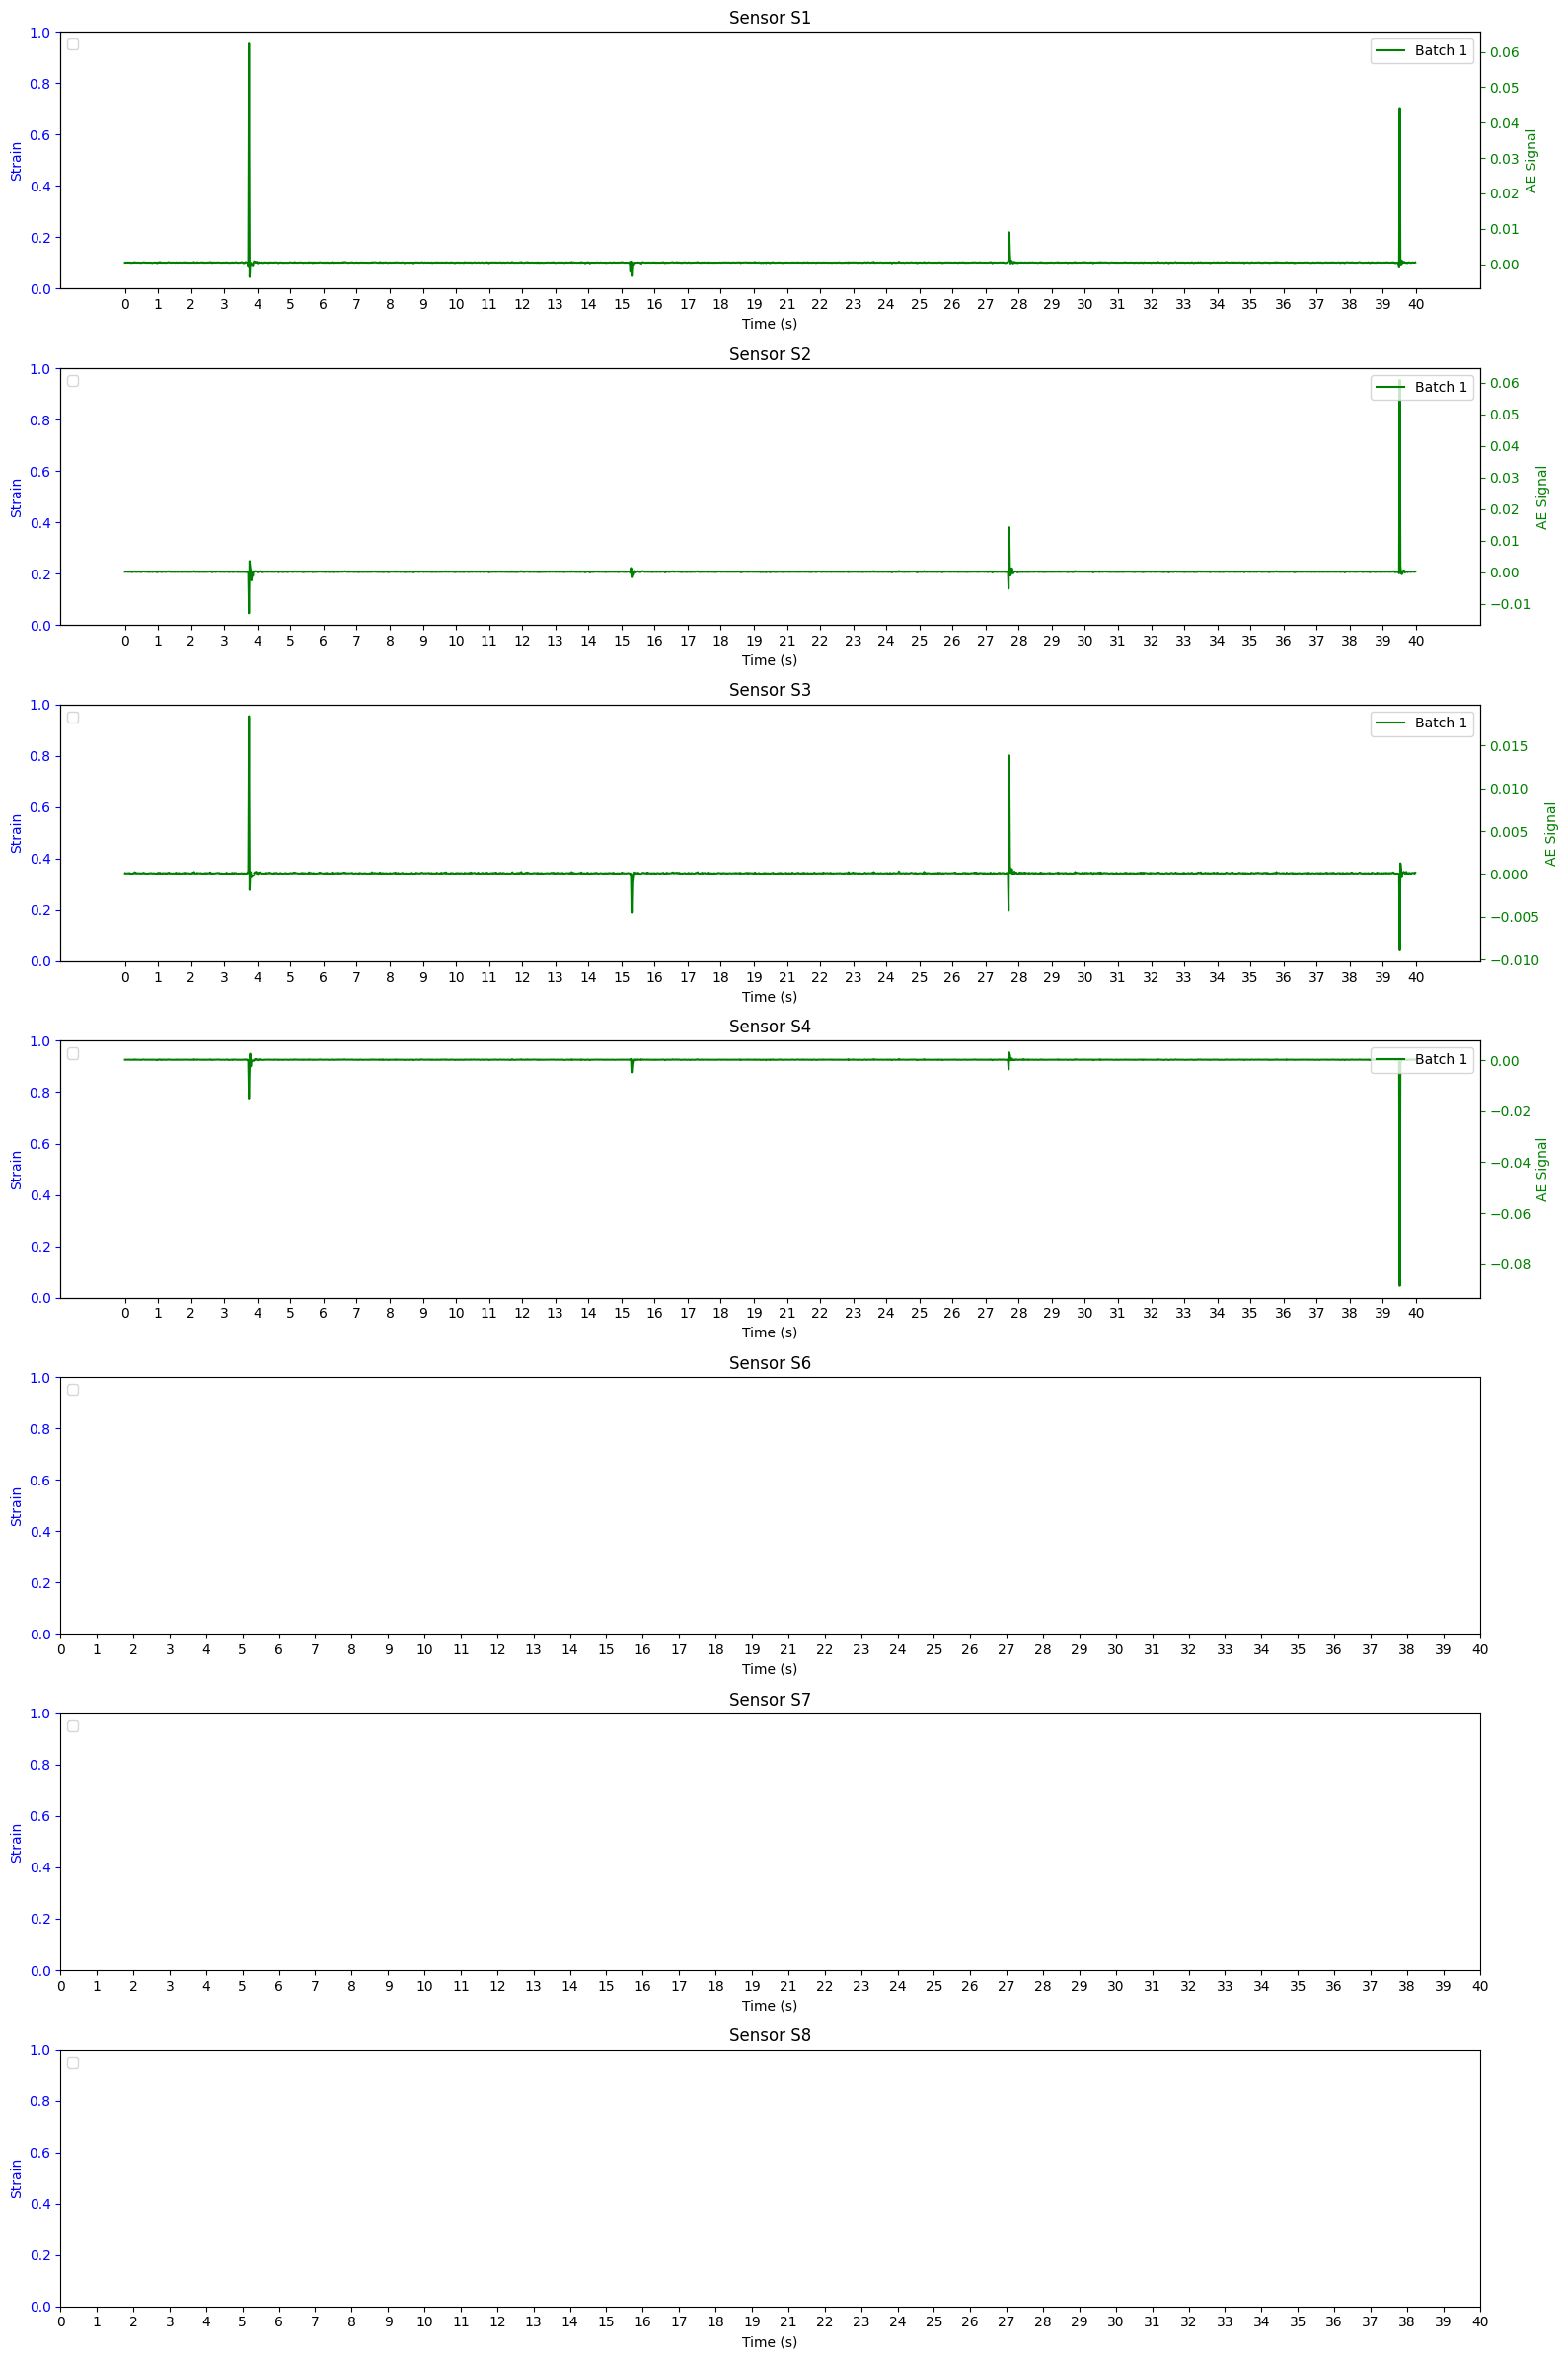

In [5]:
# Define start and end batch for the first 10 batches
start_batch = 0
end_batch = min(10, dataset.batches[1].shape[0])  # Ensure we don't exceed available batches

# Extract the necessary data
strain_data = dataset.batches[1][:end_batch, :, 1:]
strain_time = dataset.batches[1][:end_batch, :, 0]
ae_data = dataset.batches[2][:end_batch, :, 1:]
ae_time = dataset.batches[2][:end_batch, :, 0]
strain_sensor_labels = ['S1', 'S2', 'S3', 'S4', 'S6', 'S7', 'S8']
ae_sensor_labels = ['AE1', 'AE2', 'AE3', 'AE4']

# Create subplots for each strain sensor
fig, axes = plt.subplots(nrows=len(strain_sensor_labels), ncols=1, figsize=(16, 24))
xticks = np.linspace(start_batch * 4, end_batch * 4, num=40)

for i, ax in enumerate(axes):
    # Plot strain data for each batch
    """for batch_idx in range(start_batch, end_batch):
        ax.plot(strain_time[batch_idx], strain_data[batch_idx, :, i], label=f'Batch {batch_idx+1}' if batch_idx == 0 else "", color='blue')"""
    
    if i < len(ae_sensor_labels):
        ax2 = ax.twinx()  # Create a second y-axis
        for batch_idx in range(start_batch, end_batch):
            ax2.plot(ae_time[batch_idx], ae_data[batch_idx, :, i], label=f'Batch {batch_idx+1}' if batch_idx == 0 else "", color='green')
        ax2.set_ylabel('AE Signal', color='green')
        ax2.tick_params(axis='y', colors='green')
        ax2.set_ylim(auto=True)
        ax2.legend(loc='upper right')
    
    ax.set_title(f'Sensor {strain_sensor_labels[i]}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Strain', color='blue')
    ax.tick_params(axis='y', colors='blue')
    ax.set_xticks(xticks)
    ax.set_xticklabels(["{:.0f}".format(tick) for tick in xticks])
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(3):
    #counter where how many non 0 entries there are in each spike_cs[i]
    print(np.count_nonzero(spike_cs[i]))


In [7]:
encoder = Delta(threshold=0.00001)

# Determine the number of batches and sensors dynamically from the dataset tensor
num_batches = dataset.batches[1].size(0)
num_sensors = dataset.batches[1].size(2)  # Corrected to use the size of the last dimension minus time

# Skip the first feature index if it's time and ensure data is in float format
# Correcting indexing to fit the [num_batches, num_samples_per_batch, num_sensors] format
tensor_data = dataset.batches[1][:, :, 1:].float()  # Skip time data, which is assumed to be the first channel
print("Shape of the tensor data to encode:", tensor_data.shape)

# Encode the data using the Delta encoder for the entire batch tensor at once
X = encoder.encode_dataset(tensor_data)
print("Encoded data shape:", X.shape)
print(X)


Shape of the tensor data to encode: torch.Size([543, 200, 7])
Encoded data shape: torch.Size([543, 200, 7])
Encoded data shape: torch.Size([543, 200, 7])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
     

In [ ]:
# Definitions assumed to be provided elsewhere in your code:
num_batches = 1  # Number of batches
num_sensors = X.size(2)  # Number of sensors per batch

strain_sensor_labels = ['S1', 'S2', 'S3', 'S4', 'S6', 'S7', 'S8']

# Create a figure with subplots
fig, axs = plt.subplots(num_batches, num_sensors, figsize=(15, 5), squeeze=False)  # Adjusted height in figsize
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Adjust spacing

# If there's only one batch, the subplots array will be 1D
axs = axs.flatten() if num_batches == 1 else axs

# Iterate over each batch and sensor
for i in range(num_batches):
    for j in range(num_sensors):
        ax = axs[j] if num_batches == 1 else axs[i, j]
        # Generate a stem plot for each batch and sensor
        markers, stems, baseline = ax.stem(X[i, :, j].numpy(), linefmt='blue', markerfmt='bo', basefmt=" ")
        ax.set_title(f'Encoded Data {strain_sensor_labels[j]}, Batch {i+1}')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Encoded Signal')
        ax.set_ylim(0, 1)  # Set y limits to only show 0 and 1 for spikes
        plt.setp(baseline, visible=False)  # Hide the baseline for clarity

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier


# Setup the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)
accuracies = []
conf_matrices = []
y_total, pred_total = [], []

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the reservoir and sampler
    res = Reservoir(inputs=X.shape[2], c=0.4, l=0.169)
    sam = SpikeCount()
    
    # Initialize the Logistic Regression wrapped in OneVsRestClassifier for multilabel classification
    clf = LogisticRegression(solver='liblinear')

    # Create the pipeline with the Reservoir, SpikeCount, and the classifier
    pipe = Pipeline(res, sam, clf)

    # Fit the pipeline on the training data
    pipe.fit(X_train, y_train)
    
    # Make predictions on the test data
    pred = pipe.predict(X_test)
    y_total.extend(y_test)
    pred_total.extend(pred)

print(accuracy(y_total, pred_total))
print(confusion_matrix(y_total, pred_total))

5it [05:10, 62.14s/it]

0.6832412523020258
[[350  58   2   0]
 [ 78  21   0   1]
 [ 16   4   0   0]
 [  8   5   0   0]]


In [29]:
#Counter number of ones in the prediction
from collections import Counter
pred_total_counts = Counter(pred_total)
print(y_total_counts)
print(pred_total_counts)


{1: 410, 2: 100, 3: 20, 4: 13}
Counter({1: 452, 2: 88, 3: 2, 4: 1})
